# TP4: Decision trees & random forests


## Import


In [1]:
# If needed, uncomment the line below:

#!conda install python-graphviz

import warnings
warnings.filterwarnings("ignore")

In [97]:
from pylab import *
#import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Load the library with the iris dataset
from sklearn.datasets import load_iris, load_wine



# Load scikit's decision tree classifier
from sklearn import tree

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# To visualize trees
import graphviz 


# Load pandas to manipulate data frames (Excel like)
import pandas as pd

# Load numpy
#import numpy as np

# Set random seed
np.random.seed(0)

In [3]:
iris = load_iris()

## Explore the data set
1. What is the structure of the object `iris` ?

2. Plot this dataset in a well chosen set of representations to explore the data.

In [4]:
print("Type of iris:", type(iris))

Type of iris: <class 'sklearn.utils.Bunch'>


1. iris is a dictionary-like object, the interesting attributes are: ‘data’, the data to learn, ‘target’, the classification labels, ‘target_names’, the meaning of the labels, ‘feature_names’, the meaning of the features, ‘DESCR’, the full description of the dataset, ‘filename’, the physical location of iris csv dataset (added in version 0.20). (scikit learn)


In [5]:
import pandas as pd

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


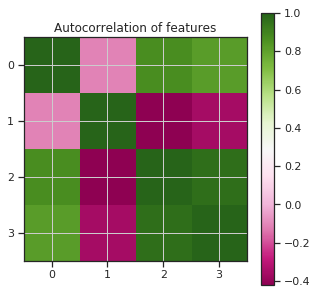

In [6]:
correlations = df.corr()
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(correlations,cmap='PiYG')
#plt.imshow(correlations,cmap='viridis')
plt.colorbar()
plt.grid(b=1)
plt.title("Autocorrelation of features")
a = ax.set_xticks(np.arange(correlations.shape[0]))
a = ax.set_yticks(np.arange(correlations.shape[0]))

The features "petal length" and "petal width" are highly correlated.

In [7]:
# Add a new column with the species number, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
#df['species']=iris.target
# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


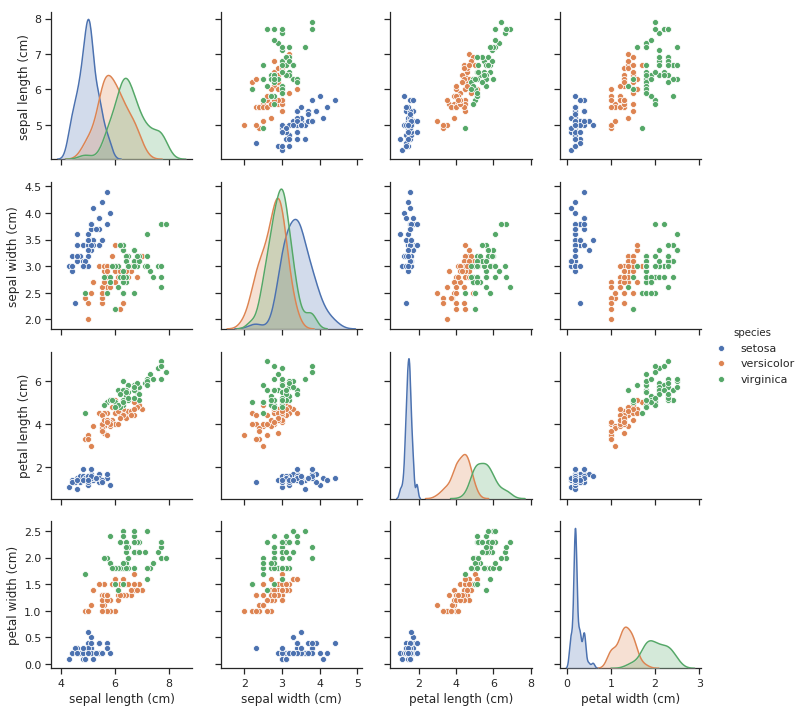

In [8]:
g = sns.pairplot(df, hue="species")

In [9]:
#df.plot.scatter(x="sepal length (cm)", y="sepal width (cm)",c="species",cmap='viridis')
#df.plot.scatter(x="sepal length (cm)", y="petal length (cm)",c="species",cmap='viridis')
#df.plot.scatter(x="sepal width (cm)", y="petal length (cm)",c="species",cmap='viridis')
#df.plot.scatter(x="petal width (cm)", y="petal length (cm)",c="species",cmap='viridis')
#plt.show()

The classes can be well separated by a threshold on the petal length features, and petal width. <br>
For example, we can draw a line for :<br>
- petal width = 0.7 and petal width = 1.7 on the 4th plot
- petal length = 2.2 and petal length = 4.9 on the 3rd plot
<br>
Thus, decision trees methods seems well adapted to the problem.

## Using `pandas` to manipulate the data
Pandas is great to manipulate data in a Microsoft Excel like way.

In [10]:
# Add a new column with the species names, this is what we are going to try to predict
#df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Step 2: create training and test sets

Create a new column that for each row, generates a random number between 0 and 1, and if that value is less than or equal to .75, then sets the value of that cell as True and false otherwise. This is a quick and dirty way of randomly assigning some rows to be used as the training data and some as the test data.

In [11]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


In [112]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [13]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 118
Number of observations in the test data: 32


We don't have a lot of data..!

In [14]:
# Create a list of the feature column's names
features = df.columns[:4]

# View features
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [159]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y_train = pd.factorize(train['species'])[0]
y_test = pd.factorize(test['species'])[0]
print("Number of class in train set 0: ",len(y_train[y_train==0]))
print("Number of class in train set 1: ",len(y_train[y_train==1]))
print("Number of class in train set 2: ",len(y_train[y_train==2]))

print("Number of class in test set 0: ",len(y_test[y_test==0]))
print("Number of class in test set 1: ",len(y_test[y_test==1]))
print("Number of class in test set 2: ",len(y_test[y_test==2]))
print(y_train.shape,y_test.shape)

Number of class in train set 0:  37
Number of class in train set 1:  43
Number of class in train set 2:  38
Number of class in test set 0:  13
Number of class in test set 1:  7
Number of class in test set 2:  12
(118,) (32,)


We have a balanced dataset. But not the same proportion of classes between train and test set

## Step 3: decision trees for the iris dataset

In [16]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train[features], y_train)

# Using the whole dataset you may use directly:
#clf = clf.fit(iris.data, iris.target)

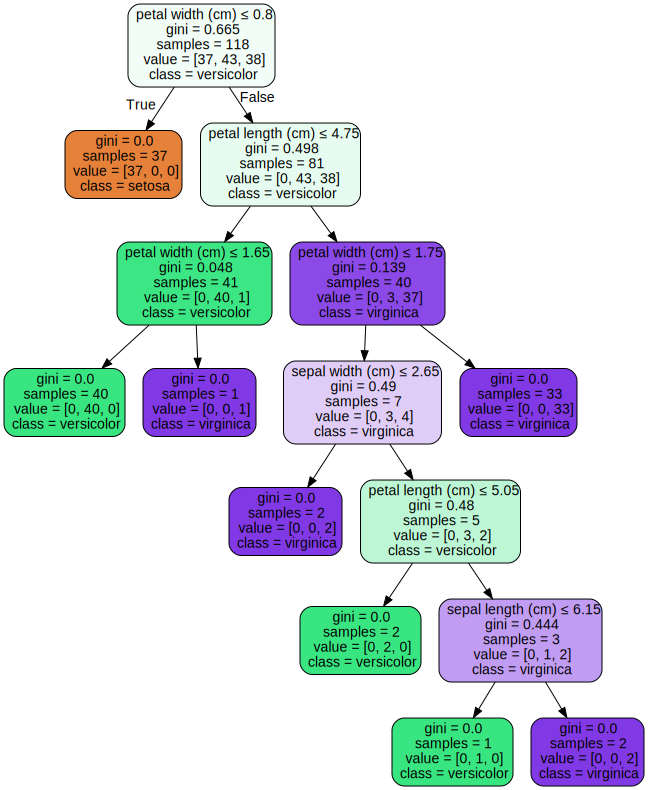

In [17]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [18]:
X_pl = np.linspace(0,8,300) # petal length
Y_pw = np.linspace(0,3,300) # petal width
mean_sl = df['sepal length (cm)'].mean()
mean_sw = df['sepal width (cm)'].mean()
XX, YY= np.meshgrid(X_pl,Y_pw)
grille_2D = np.vstack((XX.flatten(),YY.flatten())).T
grille_4D = np.hstack((np.ones(grille_2D.shape)*np.r_[mean_sl,mean_sw],grille_2D))

In [19]:
prediction_grille = clf.predict(grille_4D)
prediction_grille[prediction_grille==2].shape

(39280,)

In [20]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


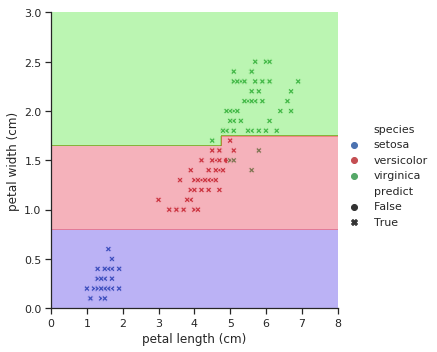

In [21]:
df['predict'] = (clf.predict(df[features])==iris.target)

sns.relplot(data=df,x="petal length (cm)", y="petal width (cm)",hue='species',style='predict',palette=['b','r','g'], )

plt.contourf(X_pl,Y_pw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)


The main discriminant features, as we saw earlier in the plots, are the petals features. Indeed, the algorithm first separate the classes thanks to the petal width and length criteria. As expected in the previous section, the decision tree discriminate with:
- petal width = 0.75 and = 1.7
- petal length = 4.95
<br>
There is a class, "setosa" which is very well separated from the others. 

In [22]:
#We can also export the tree in Graphviz format and  save the resulting graph in an output file iris.pdf:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

After being fitted, **the model can then be used to predict the class of samples**:

In [23]:
class_pred_train = clf.predict(train.values[:, :4])
class_pred_test = clf.predict(test.values[:,:4])
print("Accuracy train set: ", np.sum(class_pred_train==y_train)/y_train.shape[0])
print("Accuracy test set: ", np.sum(class_pred_test==y_test)/y_test.shape[0])

#x_train.drop(columns=['species','is_train'])
#test.drop(columns=['species','is_train'])

Accuracy train set:  1.0
Accuracy test set:  0.9375


Accuracy on train set is perfect as expected (at the end of the classification, gini = 0 for all classes). <br>
The accuracy on test set is very good too.

## Exercise 1
1. Train the decision tree on the iris dataset and explain how one should read blocks in `graphviz` representation of the tree.

2. Plot the regions of decision with the points of the training set superimposed.

*Indication: you may find the function `plt.contourf` useful.

## Exercise 2
1. Build 2 different trees based on a sepal features (sepal lengths, sepal widths) vs petal features (petal lengths, petal widths) only: which features are the most discriminant?

2. Compare performances with those obtained using all features.

3. Try the same as above using the various splitting criterion available, Gini's index, classification error or cross-entropy. Comment on your results. 

#### Only sepal featues

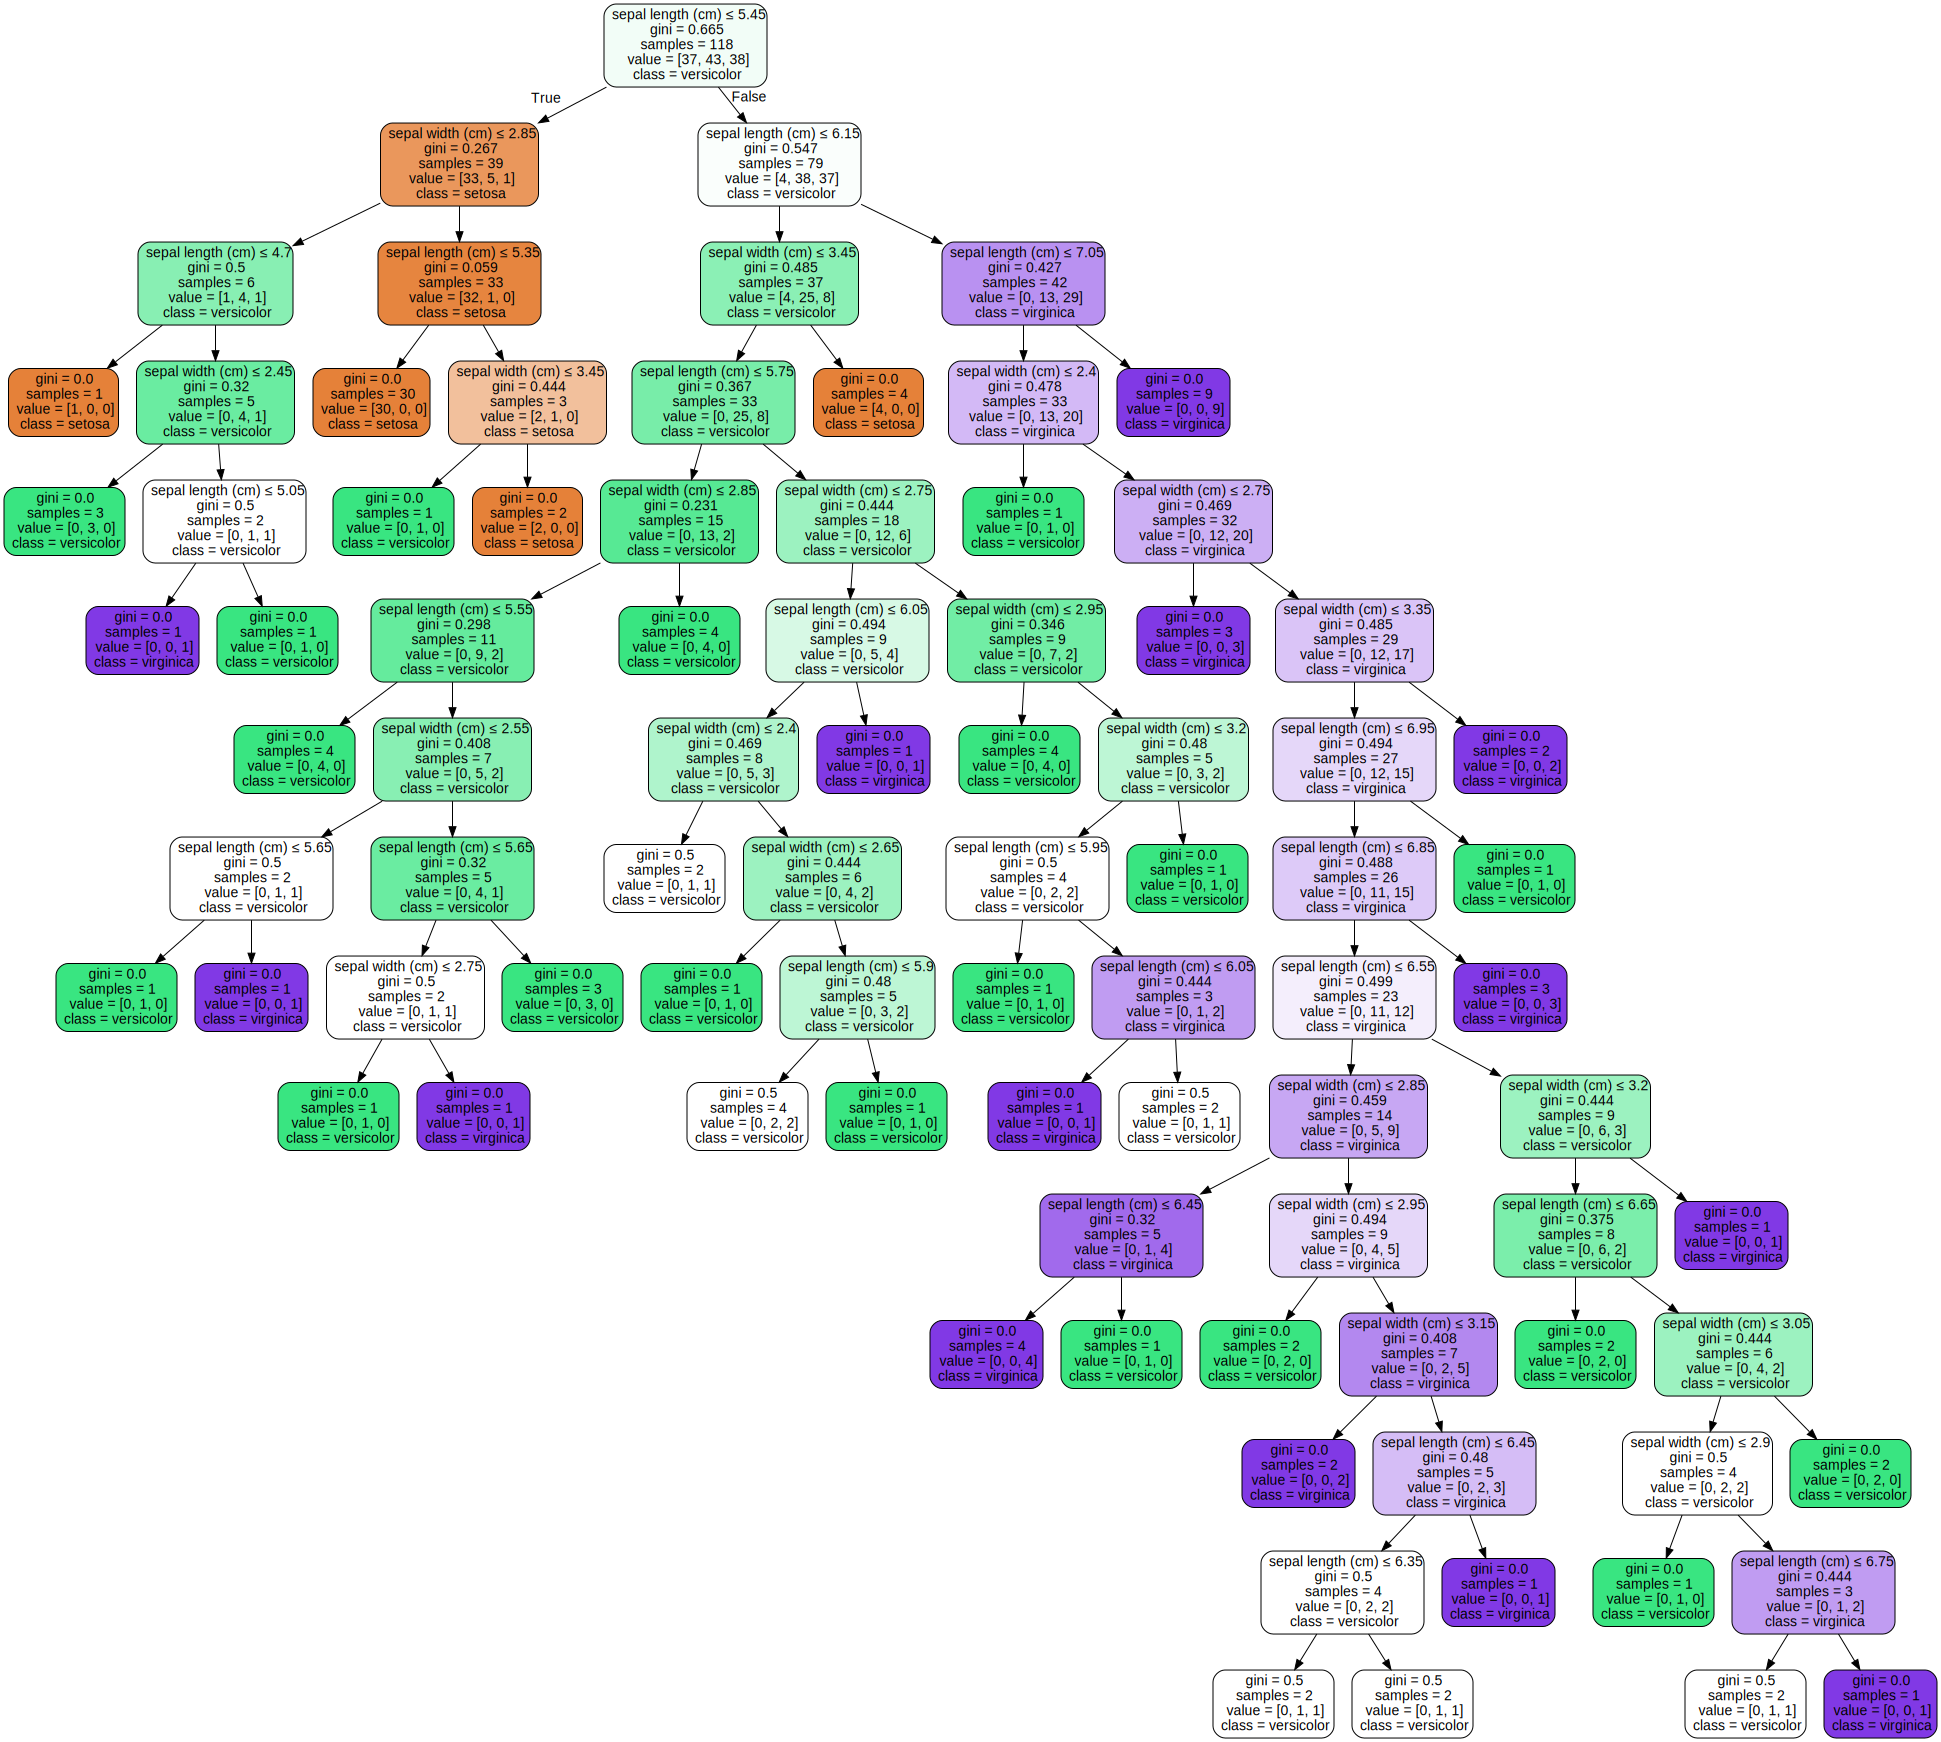

In [59]:
clf = tree.DecisionTreeClassifier()
# We fit the tree with only the first two features
clf = clf.fit(train[features[:2]], y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

We notice that the tree is very hight, with a lot of non-significant leaves (often only 1 or 2 samples per leaves).

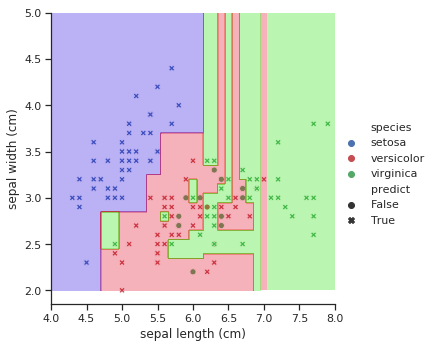

In [120]:
X_sl = np.linspace(4,8,300) # sepal length
Y_sw = np.linspace(2,5,300) # sepal width

XX, YY= np.meshgrid(X_sl,Y_sw)
grille_2D = np.vstack((XX.flatten(),YY.flatten())).T
prediction_grille = clf.predict(grille_2D)

df['predict'] = (clf.predict(df[features[:2]])==iris.target)
sns.relplot(data=df,x="sepal length (cm)", y="sepal width (cm)",hue='species',style='predict',palette=['b','r','g'], )
plt.contourf(X_sl,Y_sw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)

When we plot the decision boundary, we see that the decisions boundary are very complex, this make sense because the tree is also very high.<br>
According to the biais-variance tradeoff, the classifier would probably have a hight variance and a big generalisation error.<br>
The decision tree might have overfit the datas.

In [79]:
print("accuracy on the training set", clf.score(train[features[:2]], y_train))
print("accuracy on the  test set   ", clf.score(test[features[:2]], y_test))

accuracy on the training set 0.9067796610169492
accuracy on the  test set    0.75


We can see that the decision tree has an error of 25% on the test set. That high comparing to the previous result : 7%.   

To comfirm the previous results, and see the effect of the training set, we reproduice the previous experiments by bootstrapping the training set.

error rate on the  test set    0.3125
error rate on the  test set    0.25
error rate on the  test set    0.21875
error rate on the  test set    0.1875
error rate on the  test set    0.25
error rate on the  test set    0.3125
error rate on the  test set    0.25
error rate on the  test set    0.1875


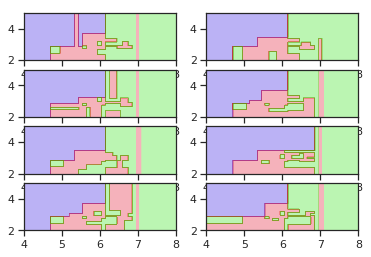

In [80]:
for i in range(8):
    plt.subplot(4,2,i+1)
    train_sample = train.sample(100)
    y_train_sample = pd.factorize(train_sample['species'],sort='unique')[0]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_sample[features[:2]], y_train_sample)
    prediction_grille = clf.predict(grille_2D)
    plt.contourf(X_sl,Y_sw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)
    print("error rate on the  test set   ", 1-clf.score(test[features[:2]], y_test))

We have errors rates in the same order than previously.<br>
Futhermore, the decisions boundaries vary widely between to trainings sets. <br>
That is due to the instability of decisions tree and hight complexity (overfitting)

#### Only petal features

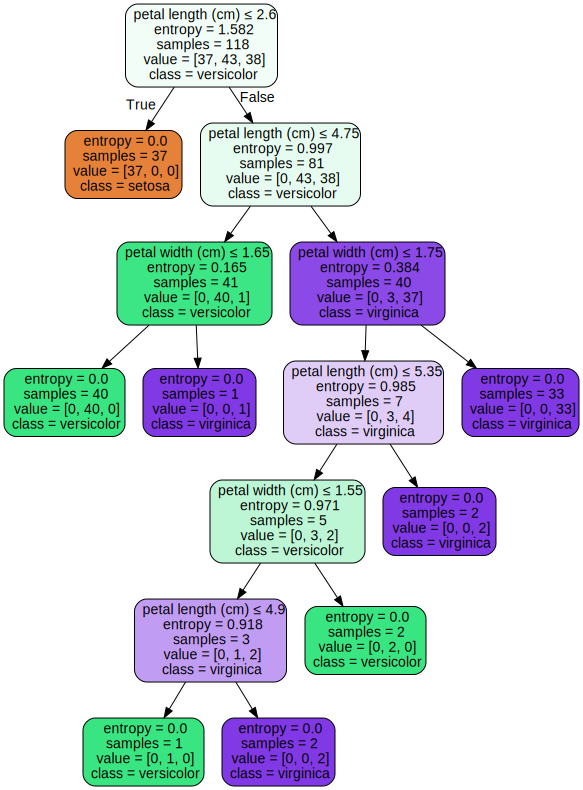

In [69]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
# We fit the tree with only the last two features
clf = clf.fit(train[features[2:]], y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names[2:],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

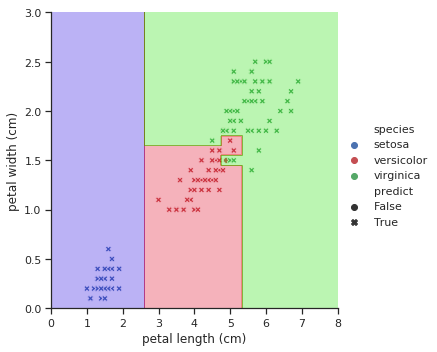

In [82]:
X_pl = np.linspace(0,8,300) # petal length
Y_pw = np.linspace(0,3,300) # petal width

XX, YY= np.meshgrid(X_pl,Y_pw)
grille_2D = np.vstack((XX.flatten(),YY.flatten())).T
prediction_grille = clf.predict(grille_2D)

df['predict'] = (clf.predict(df[features[2:]])==iris.target)
sns.relplot(data=df,x="petal length (cm)", y="petal width (cm)",hue='species',style='predict',palette=['b','r','g'], )
plt.contourf(X_pl,Y_pw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)

Decisions boundaries are simplier as before.

In [83]:
print("accuracy on the training set", clf.score(train[features[2:]], y_train))
print("accuracy on the  test set   ", clf.score(test[features[2:]], y_test))

accuracy on the training set 1.0
accuracy on the  test set    0.90625


accuracy on the  test set    0.09375
accuracy on the  test set    0.03125
accuracy on the  test set    0.03125
accuracy on the  test set    0.09375
accuracy on the  test set    0.03125
accuracy on the  test set    0.03125
accuracy on the  test set    0.09375
accuracy on the  test set    0.03125


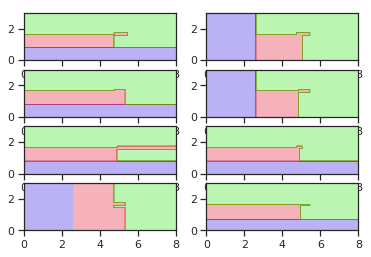

In [85]:
for i in range(8):
    plt.subplot(4,2,i+1)
    train_sample = train.sample(100)
    y_train_sample = pd.factorize(train_sample['species'],sort='unique')[0]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_sample[features[2:]], y_train_sample)
    prediction_grille = clf.predict(grille_2D)
    plt.contourf(X_pl,Y_pw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)
    print("accuracy on the  test set   ", 1-clf.score(test[features[2:]], y_test))

The decisions boundaries still sensitive to the training set because it is decision tree.<br>
The errors rates are low comparing to the previous tree, and in the same order than the tree using all features.<br>
It is possible to build a tree with good result using only two features.

#### try with an other splitting criterion

accuracy on the  test set    0.375
accuracy on the  test set    0.4375
accuracy on the  test set    0.53125
accuracy on the  test set    0.5
accuracy on the  test set    0.375
accuracy on the  test set    0.4375
accuracy on the  test set    0.46875
accuracy on the  test set    0.4375


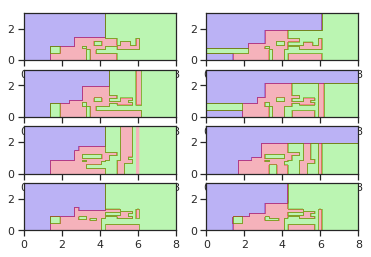

In [121]:
for i in range(4):
    plt.subplot(4,2,2*i+1)
    train_sample = train.sample(100)
    y_train_sample = pd.factorize(train_sample['species'],sort='unique')[0]
   
    clf = tree.DecisionTreeClassifier(criterion='gini')
    clf = clf.fit(train_sample[features[:2]], y_train_sample)
    prediction_grille = clf.predict(grille_2D)
    plt.contourf(X_pl,Y_pw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)
    print("accuracy on the  test set   ", 1-clf.score(test[features[2:]], y_test))
    
    plt.subplot(4,2,2*i+2)
    clf = tree.DecisionTreeClassifier(criterion='entropy')
    clf = clf.fit(train_sample[features[:2]], y_train_sample)
    prediction_grille = clf.predict(grille_2D)
    plt.contourf(X_pl,Y_pw,prediction_grille.reshape(300,300),cmap='brg',alpha = 0.3)
    print("accuracy on the  test set   ", 1-clf.score(test[features[2:]], y_test))

### Going further ahead (not mandatory) 
Try the same approach adapted to another toy dataset from `scikit-learn` described at:
http://scikit-learn.org/stable/datasets/index.html

Play with another dataset available at:
http://archive.ics.uci.edu/ml/datasets.html

## Step 4: Random forests
Go to 

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

for a documentation about the `RandomForestClassifier` provided by `scikit-learn`.

Since target values must be integers, we first need to transform labels into numbers as below.

In [86]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y = pd.factorize(train['species'])[0]

# View target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [87]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

**Make predictions** and create actual english names for the plants for each predicted plant class:

In [88]:
preds = rf.predict(test[features])
preds_names = pd.Categorical.from_codes(preds, iris.target_names)
preds_names

[setosa, setosa, setosa, setosa, setosa, ..., virginica, virginica, virginica, virginica, virginica]
Length: 32
Categories (3, object): [setosa, versicolor, virginica]

### Create a confusion matrix

In [89]:
# Create confusion matrix unsing pandas:
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,0,1,2
Actual Species,,,
setosa,13,0,0
versicolor,0,5,2
virginica,0,0,12


## Feature selection using random forests byproducts

One of the interesting use cases for random forest is feature selection. One of the byproducts of trying lots of decision tree variations is that you can examine which variables are working best/worst in each tree.

When a certain tree uses one variable and another doesn't, you can compare the value lost or gained from the inclusion/exclusion of that variable. The good random forest implementations are going to do that for you, so all you need to do is know which method or variable to look at.

### View feature importance
While we don't get regression coefficients like with ordinary least squares (OLS), we do get a score telling us how important each feature was in classifying. This is one of the most powerful parts of random forests, because we can clearly see that petal width was more important in classification than sepal width.


In [90]:
# View a list of the features and their importance scores
list(zip(train[features], rf.feature_importances_))

[('sepal length (cm)', 0.11185992930506346),
 ('sepal width (cm)', 0.016341813006098178),
 ('petal length (cm)', 0.36439533040889194),
 ('petal width (cm)', 0.5074029272799464)]

As see previously, the petals features are more important than the peatals features.<br>
But we also see/learn that "sepal length" are more important than "sepal width".
And that "petal width" are more important than "petal length".

## Exercise 3
1. Comment on the feature importances with respect to your previous observations on decision trees above.

2. Extract and visualize 5 trees belonging to the random forest using the attribute `estimators_` of the trained random forest classifier. Compare them. *Note that you may code a loop on extracted trees.*

3. Study the influence of parameters like `max_depth`, `min_samples_leaf` and `min_samples_split`. Try to optimize them and explain your approach and choices.

4. How is estimated the prediction error of a random forest ?
*Indication: have a look at parameter `oob_score`.*
What are out-of-bag samples ?

5. What should you do when classes are not balanced in the dataset ? (that is when there are much more examples of one class than another)

In [256]:
for clf in rf.estimators_[:5]:
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph
    graphviz.Source(dot_data).view()

In [255]:
clf = rf.estimators_[1]
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graphviz.Source(dot_data).view()

'Source.gv.pdf'

### Hyper-parameter optimization

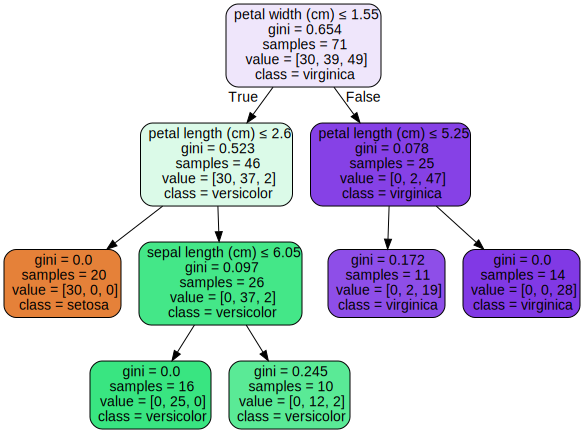

In [260]:
dict_param = {'max_depth':10,
            'min_samples_leaf':10,
            'min_samples_split':10,
             'oob_score':True}
clf = RandomForestClassifier(n_jobs=2, random_state=0,**dict_param)
clf.fit(train[features], y)
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

#### Cross Validation

In [224]:
shuffle_train = train.sample(frac=1)
shuffle_train['species'] =  pd.factorize(shuffle_train['species'],sort='unique')[0]
set_size = train.shape[0]
K = 10
n = set_size//K

val_max_depth = [1,2,3,4,5,6,7,8,9]
val_min_samples_leaf = [1,2,3,4,5,6,7,8,9]
val_min_samples_split = [2,3,4,5]

moy_vals = np.zeros((len(val_max_depth),
                    len(val_min_samples_leaf),
                    len(val_min_samples_split)))

for l in range(K):
    train_set = np.vstack((shuffle_train.values[:l*n],shuffle_train.values[(l+1)*n:]))
    validation_set = shuffle_train.values[l*n:(l+1)*n]
    train_set = train_set.astype(np.float64)
    validation_set = validation_set.astype(np.float64)

    X_train, y_train = train_set[:,:4],train_set[:,4]
    X_validation, y_validation = validation_set[:,:4],validation_set[:,4]
    
    for i in range(len(valeurs_max_depth)):
        for j in range(len(val_min_samples_leaf)):
            for k in range(len(val_min_samples_split)):
                dict_param = {'max_depth':val_max_depth[i],
                              'min_samples_leaf':val_min_samples_leaf[j],
                             'min_samples_split':val_min_samples_split[k]}
                clf = RandomForestClassifier(n_jobs=2, random_state=0,**dict_param)
                clf.fit(X_train, y_train)
                moy_vals[i,j,k] += clf.score(X_validation, y_validation)
    print(l)
moy_vals /= K

0
1
2
3
4
5
6
7
8
9


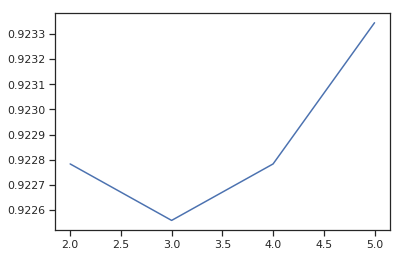

In [225]:
plt.plot(val_min_samples_split,moy_vals.mean(axis=0).mean(axis=0))

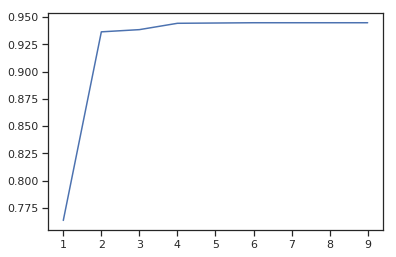

In [226]:
plt.plot(val_max_depth,moy_vals.mean(axis=2).mean(axis=1))

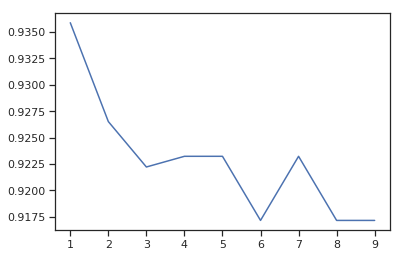

In [228]:
plt.plot(val_min_samples_leaf,moy_vals.mean(axis=0).mean(axis=1))

In [259]:
rf.oob_score

False

## Step 5: a small example of regression using random forests
Random forest is capable of learning without carefully crafted data transformations. Take the the $f(x) = \sin(x)$ function for example.

Create some fake data and add a little noise.

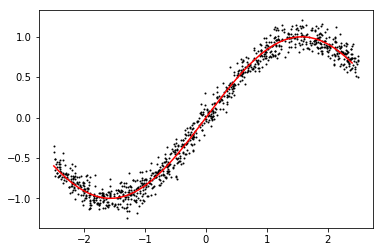

In [6]:
x = np.random.uniform(-2.5, 2.5, 1000)
y = np.sin(x) + np.random.normal(0, .1, 1000)

plt.plot(x,y,'ko',markersize=1,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.show()

If we try and build a basic linear model to predict y using x we end up with a straight line that sort of bisects the sin(x) function. Whereas if we use a random forest, it does a much better job of approximating the sin(x) curve and we get something that looks much more like the true function.

Based on this example, we will illustrate how the random forest isn't bound by linear constraints.

## Exercise 4
1. Apply random forests on this dataset for regression and compare performances with ordinary least squares regression.
*Note that ordinay least square regression is available thanks to:
from sklearn.linear_model import LinearRegression*

2. Comment on your results.

### Indications:
You may use half of points for training and others to test predictions. Then you will have an idea of how far the random forest predictor fits the sinus curve.

To this aim, you will need to use the model `RandomForestRegressor`. Be careful that when only 1 feature `x` is used as an input, you will need to reshape it by `x.reshape(-1,1)` when using methods `fit` and `predict`.

In [ ]:
regrf = RandomForestRegressor(n_estimators=30, max_depth=4)
regrf.fit(x[0::2].reshape(-1, 1),y[0::2])

In [ ]:
from sklearn.linear_model import LinearRegression
...

### Indication
One clever way to compare models when using `scikit-learn`is to make a loop on models as follows:

In [ ]:
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)]

for model in models:
    ...
    


## Documentation

### Decision trees
http://scikit-learn.org/stable/modules/tree.html

### Random forests
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Plot decision surface : using `plt.contourf`
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py


## Pruning trees: not available in scikit-learn.
Since post-pruning of tree is not implemented in scikit-learn, you may think of coding your own pruning function. For instance, taking into account the numer of samples per leaf as proposed below:

In [ ]:
# Pruning function (useful ?)
def prune(decisiontree, min_samples_leaf = 1):
    if decisiontree.min_samples_leaf >= min_samples_leaf:
        raise Exception('Tree already more pruned')
    else:
        decisiontree.min_samples_leaf = min_samples_leaf
        tree = decisiontree.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree.children_left[i]=-1
                tree.children_right[i]=-1
                